In [ ]:
import riskparity
import mpt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
import numpy as np

# Takes initial year and adds num_years to it
def year(initial_year, num_years):
    date_obj = initial_year
    if type(initial_year) == str:
        new_date = datetime.strptime(initial_year, "%Y-%m-%d")
    else:
      new_date = date_obj + relativedelta(years=num_years)
    return new_date, new_date.strftime("%Y-%m-%d")


# Tickers: list of asset tickers
# b: RRCs
# year_range_start: date to start from
# years: number of years in long run
def optimal_portfolio_returns(tickers, b, year_range_start, years, short_run_years):
    
    current_date = datetime.strptime(year_range_start, "%Y-%m-%d")
    print(type(current_date))
    final_date, final_date_str = year(year_range_start, years)
    data = yf.download(tickers, start=year_range_start, end=final_date_str)["Adj Close"]
    print("DATA:", data)
    market_data = yf.download("^GSPC", start=year_range_start, end=final_date_str)["Adj Close"]

    rf_rate = 0.045 / 252


    # Loop through all short term periods, each 5 years on a 6 month sliding window basis
    x_axis_mpt = []
    y_axis_rp = []
    while current_date <= final_date:
        end_date, end_date_str = year(current_date, short_run_years)
        # MPT Portfolio
        
        max_sharpe_return, max_sharpe_volatility, df = mpt.find_best_portfolio(data, market_data, rf_rate, current_date, end_date)
        x_axis_mpt.append(df["Values"])


        # Ex-Ante Risk Parity Portfolio
        # Loop through every month for 5 years
        current_ex_ante_date = current_date
        total_returns = 0
        while current_ex_ante_date <= end_date:
          # Use data from two years prior to make predictions
          two_years_prior = year(current_ex_ante_date, -2)
          end_ex_ante_date = current_ex_ante_date + relativedelta(months = 1)
          # Get RRC weights
          rp_weights = riskparity.produce_rbp_stats(data, b, two_years_prior, current_ex_ante_date)
          # Get returns for the month
          month_returns =  mpt.portfolio_returns(current_ex_ante_date, end_ex_ante_date, data, rp_weights)
          total_returns += month_returns
          current_ex_ante_date = end_ex_ante_date + relativedelta(days=1)
        
        rp_sharpe = -1 * mpt.negative_sharpe_ratio(rp_weights, total_returns)
        y_axis_rp.append(rp_sharpe)
        current_date = end_date + relativedelta(years = 0.5)
    return x_axis_mpt, y_axis_rp


def rrc_score():
  pass

# tickers = ["^GSPC", "^TNX"]
tickers = ["AAPL", "NVDA"]
b = np.array([1.4, 1])
start_date="2000-01-01"
end_date="2025-01-01"

optimal_portfolio_returns(tickers, b, start_date, 24, 5)

<class 'datetime.datetime'>


[*********************100%***********************]  2 of 2 completed

2 Failed downloads:
['AAPL', 'NVDA']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^GSPC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
c:\Users\jmacy\JupyterProjects\Portfolio\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\jmacy\JupyterProjects\Portfolio\.venv\Lib\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\jmacy\JupyterProjects\Portfolio\.venv\Lib\site-packages\pandas\core\frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
c:\Users\jmacy\JupyterProjects\Portfolio\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encounte

DATA: Empty DataFrame
Columns: [AAPL, NVDA]
Index: []
nan
nan
{'AAPL': np.float64(nan), 'NVDA': np.float64(nan)}
Daily Expected Market Return: nan
Expected Daily Returns: [nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


[*********************100%***********************]  3 of 3 completed

Optimized Weights: [0.36020472 0.41411445 0.22568083]


<Figure size 800x600 with 0 Axes>

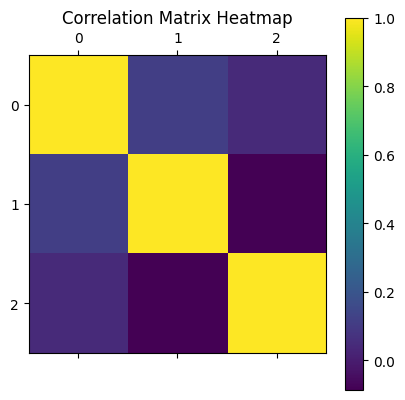

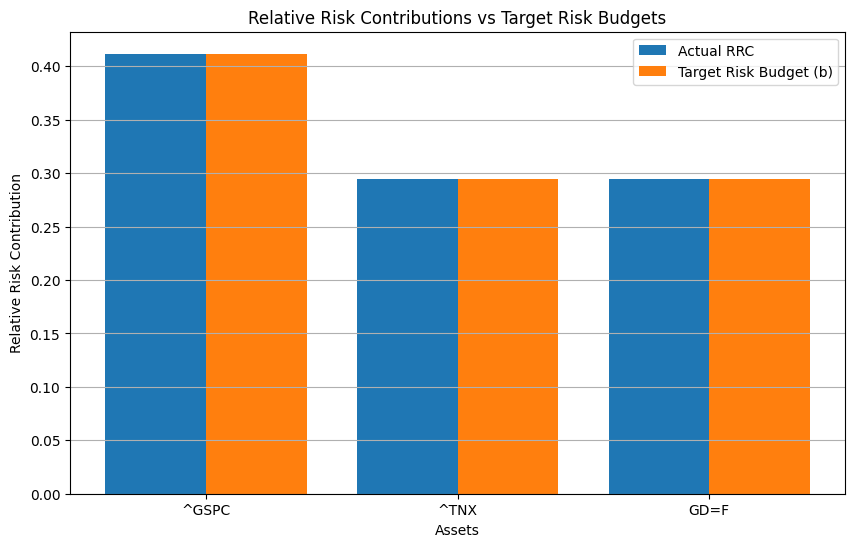

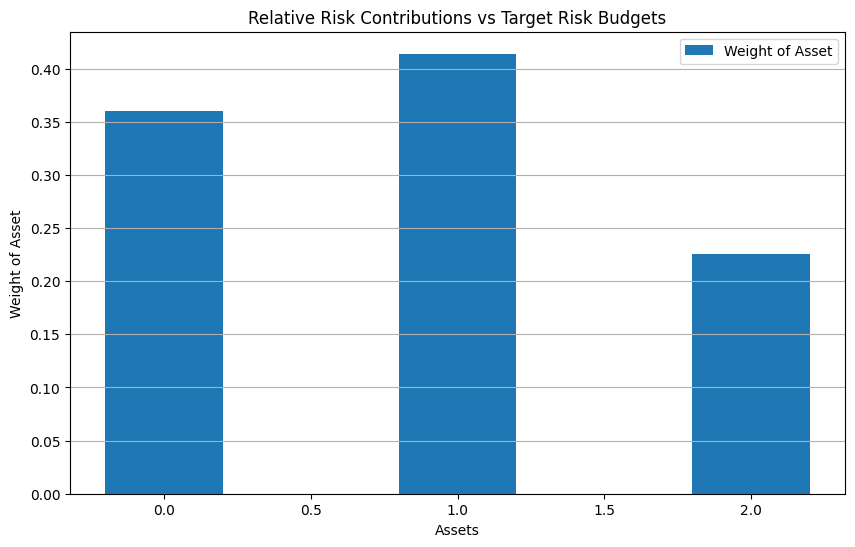

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
 
def risk_budgeting_portfolio(cov_matrix, b, tol=1e-8, max_iter=1000):
    N = len(b)
    w = np.ones(N) / N  # Initial equal weights

    for _ in range(max_iter):
        w_old = w.copy()

        for i in range(N):
            # Marginal Risk Contribution = dvol / dweight = (Cov * b)_i / (b.T * Cov * b) ** 0.5
            # Risk Contribution = w_i * marginal risk contribution
            # Relative risk contribution = Risk Contribution / Total Risk = w_i * marginal risk contribution / (b.T * Cov * b)    
            total_risk = np.dot(w.T, np.dot(cov_matrix, w))

            # Update weight for asset i
            w_i_new = (b[i] * total_risk) / np.dot(cov_matrix[i, :], w)
            w[i] = max(w_i_new, 0)  # Ensure non-negativity

        # Normalize weights
        w = w / np.sum(w)

        # Convergence check
        if np.linalg.norm(w - w_old) < tol:
            break

    return w

def visualize_rrc(corr_matrix, cov_matrix, w, b, tickers):
    b = b / np.sum(b)

    sigma_w = cov_matrix @ w
    total_risk = w @ sigma_w
    
    # Risk Contributions (RC)
    rc = w * sigma_w
    
    # Relative Risk Contributions (RRC)
    rrc = rc / total_risk

    # Plotting correlation 
    plt.figure(figsize=(8, 6))
    plt.matshow(corr_matrix)  # `fignum=1` ensures it uses the current figure
    plt.colorbar()
    plt.title('Correlation Matrix Heatmap')
    plt.show()


    # Plotting RCC to b
    plt.figure(figsize=(10, 6))
    indices = np.arange(len(w))
    plt.bar(indices - 0.2, rrc, width=0.4, label='Actual RRC')
    plt.bar(indices + 0.2, b, width=0.4, label='Target Risk Budget (b)')
    plt.xlabel('Assets')
    plt.ylabel('Relative Risk Contribution')
    plt.title('Relative Risk Contributions vs Target Risk Budgets')
    plt.xticks(indices, tickers)  # Add ticker labels

    plt.legend()
    plt.grid(axis='y')
    plt.show()


    # Plotting Weights
    plt.figure(figsize=(10, 6))
    indices = np.arange(len(w))
    plt.bar(indices, w, width=0.4, label='Weight of Asset')
    plt.xlabel('Assets')
    plt.ylabel('Weight of Asset')
    plt.title('Relative Risk Contributions vs Target Risk Budgets')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

def produce_rbp_stats(tickers, b, start_date, end_date):
    # Download historical data
    data = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]
    data = data.pct_change().dropna()

    # Calculate covariance and correlation matrices
    corr_matrix = data.corr().values
    cov_matrix = data.cov().values

    # Ensure `b` is normalized
    b = b / np.sum(b)

    # Check covariance matrix is positive semi-definite
    eigenvalues = np.linalg.eigvals(cov_matrix)
    if np.any(eigenvalues < 0):
        print("Covariance matrix is not positive semi-definite. Adjusting...")
        cov_matrix = cov_matrix @ cov_matrix.T  # Make positive semi-definite

    # Calculate weights
    weights = risk_budgeting_portfolio(cov_matrix, b)
    print("Optimized Weights:", weights)

    # Visualize results
    visualize_rrc(corr_matrix, cov_matrix, weights, b, tickers)
   

produce_rbp_stats(["^GSPC", "^TNX", "GD=F"], np.array([1.4, 1, 1]), start_date="2022-01-01", end_date="2024-12-31")
